### Tutorial for Bayesian Optimization:


Source: Practical Bayesian Optimization of Machine Learning Algorithms

Link: https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf


In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Our imports 
from gp import GP, SquaredExp, Matern52
import sampling as s


sns.set_palette('muted',color_codes=True)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Plotting helpers         
def plot_draws(x,draws):
    """ Plot the draws from the GP prior or posterior """
    for p in draws.T:
        plt.plot(sorted(x),sorted(p,key=dict(zip(p, x)).get),alpha=0.8)
    plt.xlabel('x')
    plt.ylabel('prior y')
    sns.despine()

def plot_posterior(post_means, post_std, xp):
    sorted_x = sorted(xp.ravel())
    sort_means = np.array(sorted(post_means,key=dict(zip(post_means, xp.ravel())).get))
    sort_std = np.array(sorted(post_std,key=dict(zip(post_std, xp.ravel())).get))
    
    plt.plot(sorted_x,sort_means,alpha=0.7, label='Posterior Mean')
    plt.gca().fill_between(sorted_x, sort_means-3*sort_std, sort_means+3*sort_std, alpha=0.3)

### Draws from the prior distribution

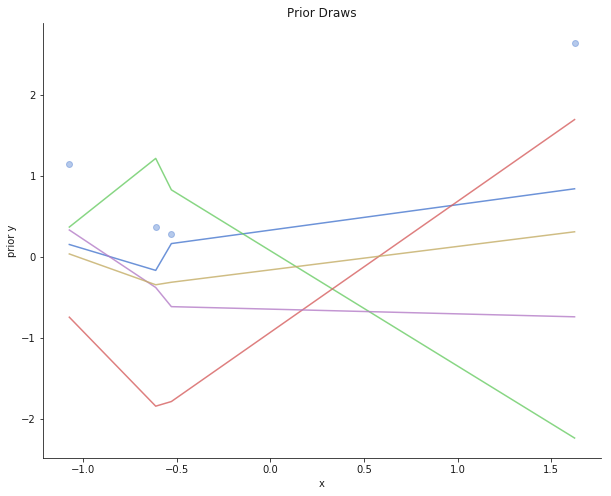

In [81]:
# Example - Initials 
np.random.seed(1)
x = np.random.randn(4,1)
y = x**2

# Make GP
ggp = GP(x,y,Matern52)
# ggp = GP(x,y,SquaredExp)

# Draw prior functions from GP
prior_draws = ggp.draw_prior(5)

# Plotting prior functions 
plt.figure(figsize=(10,8))
plt.scatter(x,y,alpha=0.4)
plot_draws(x,prior_draws)
plt.title('Prior Draws')
plt.show()

### Draws from the posterior and posterior predictive distribution

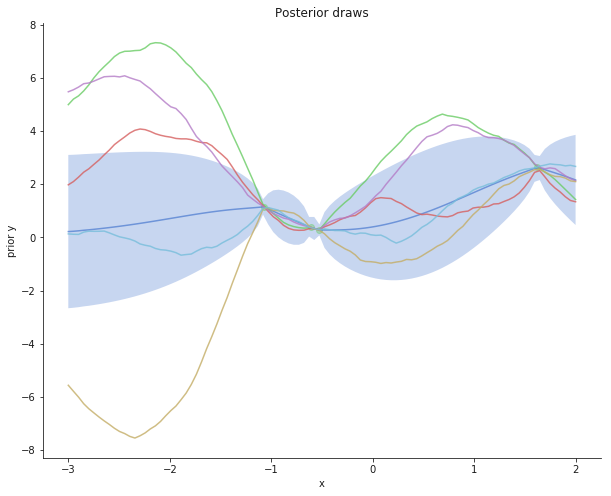

In [82]:
np.random.seed(5)
xp = np.linspace(-3,2,100).reshape(-1,1)

# Draw from the posterior and posterior predictive
post_means, post_stds = ggp.draw_posterior(xp)
pp_draws = ggp.draw_posterior_pred(5)

# Plotting posterior and posterior predictive 
plt.figure(figsize=(10,8))
plot_posterior(post_means, post_stds, xp)
plt.scatter(x,y,alpha=0.4)
plot_draws(xp,pp_draws)
plt.title('Posterior draws')
sns.despine()
plt.show()

### Lets look at all the available acquisition functions

* Probability of Improvement 
* Expected Improvement 
* GP Lower Confidence Bound 

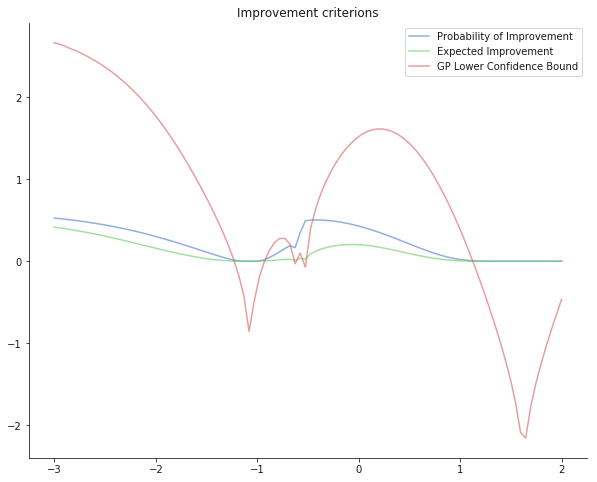

In [83]:
# Plotting the different improvement criterions 
plt.figure(figsize=(10,8))
plt.plot(xp,ggp.pi_metric(xp),label='Probability of Improvement',alpha=0.6)
plt.plot(xp,ggp.ei_metric(xp),label='Expected Improvement',alpha=0.6)
plt.plot(xp,ggp.ucb_metric(xp,3),label='GP Lower Confidence Bound',alpha=0.6)
# plt.plot(xp,post_means,label='Mean of Posterior',alpha=0.6)
plt.title('Improvement criterions')
plt.legend()
sns.despine()


### Different $\theta$'s for varying GP hyperparameters

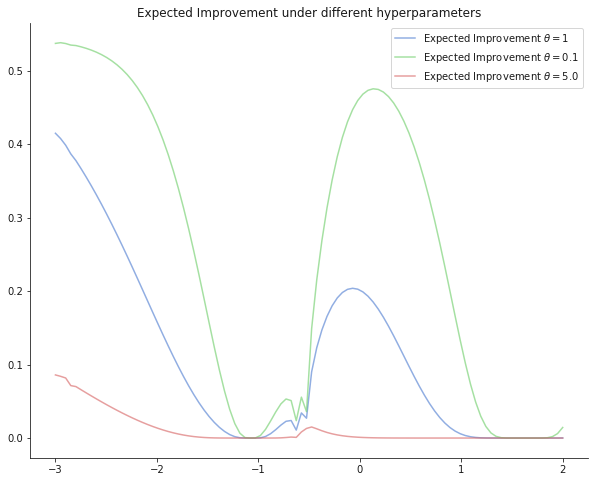

In [87]:
# Plotting 
plt.figure(figsize=(10,8))
plt.plot(xp,ggp.ei_metric(xp),label=r'Expected Improvement $\theta=1$',alpha=0.6)
ggp.thetas = np.array([0.5])
plt.plot(xp,ggp.ei_metric(xp),label=r'Expected Improvement $\theta=0.1$',alpha=0.6)
ggp.thetas = np.array([5.0])
plt.plot(xp,ggp.ei_metric(xp),label=r'Expected Improvement $\theta=5.0$',alpha=0.6)
plt.title('Expected Improvement under different hyperparameters')
plt.legend()
sns.despine()

# Reset thetas 
ggp.thetas = np.array([1.0])

### Example with a simple function, $f(x)=x^2$

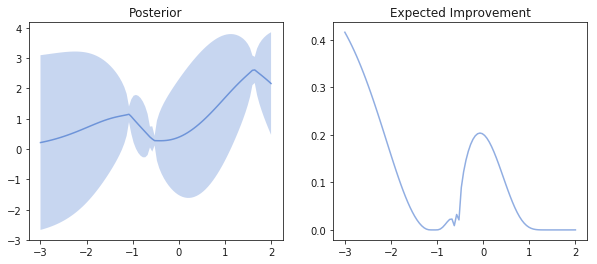

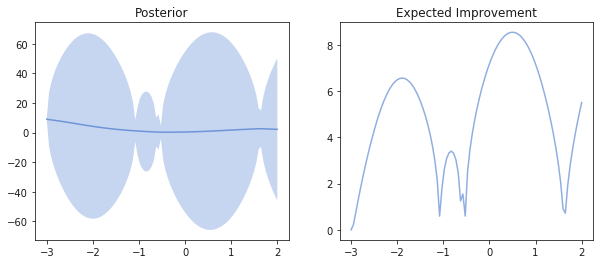

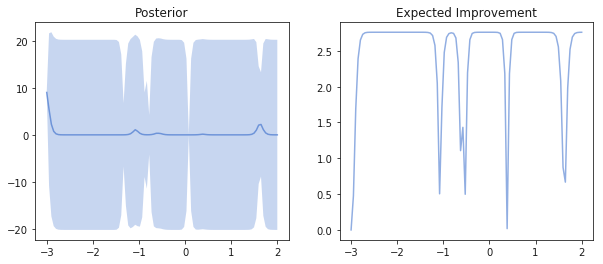

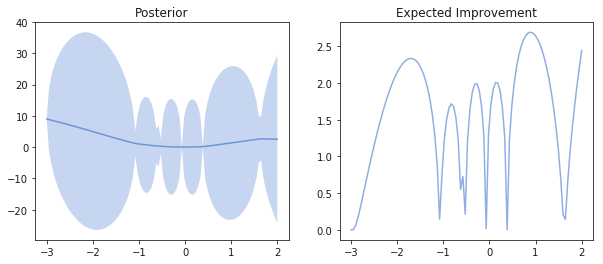

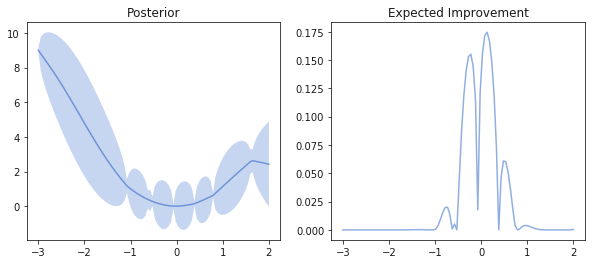

In [10]:
func = lambda x: x**2
hist = []
for i in range(5):
    # Plotting
    post_means, post_stds = ggp.draw_posterior(xp)
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plot_posterior(post_means, post_stds, xp)
    plt.title('Posterior')
    
    plt.subplot(122)
    plt.plot(xp,ggp.ei_metric(xp),label=f'Expected Improvement at {i}',alpha=0.6)
    plt.title('Expected Improvement')
    plt.show()
    
    # The actual bayesian optimization part
    next_prop = ggp.next_proposal(xp)
    next_val = xp[next_prop].reshape(-1,xp.shape[1])
    prop_res = func(next_val).reshape(-1,1)
    ggp.obsx = np.append(ggp.obsx, next_val, axis=0)
    ggp.obsy = np.append(ggp.obsy, prop_res, axis=0)
    hist.append((next_prop,prop_res))


In [14]:
print(f'The optimal x value we found was: {xp[min(hist,key= lambda x: x[1])[0]]}')

The optimal x value we found was: [-0.07070707]


### Here is the whole process for $f(x)=x^2$

In [19]:
np.random.seed(1)
func = lambda x: x**2
x = np.random.randn(4,1)
y = func(x)

# Make GP
ex_gp = GP(x,y,Matern52)

x_proposed = np.linspace(-5,5,100).reshape(-1,1)
best_res, ex_hist = ex_gp.find_best(func,x_proposed,iters=10)
print(f'Best result was {best_res[1]} achieved at x = {best_res[0]}')

Best result was [[ 0.00255076]] achieved at x = [[ 0.05050505]]


### Example with Rosenbrock

In [69]:
np.random.seed(1)
rosen = lambda x: (1-x[:,0])**2+100*(x[:,1]-x[:,0]**2)**2
rx = np.random.randn(4,2)
ry = rosen(rx)

# Make GP
rosen_gp = GP(rx,ry,Matern52)

rx_proposed = np.array(np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))).reshape(-1,2)
best_res, rosen_hist = rosen_gp.find_best(rosen,rx_proposed,iters=10)

100%|██████████| 10/10 [01:37<00:00,  9.76s/it]

Best result was [[ 1.64590868]] achieved at x = [[ 0.10204082  0.10204082]]


Best result was [ 1.64590868] achieved at x = [ 0.10204082  0.10204082]


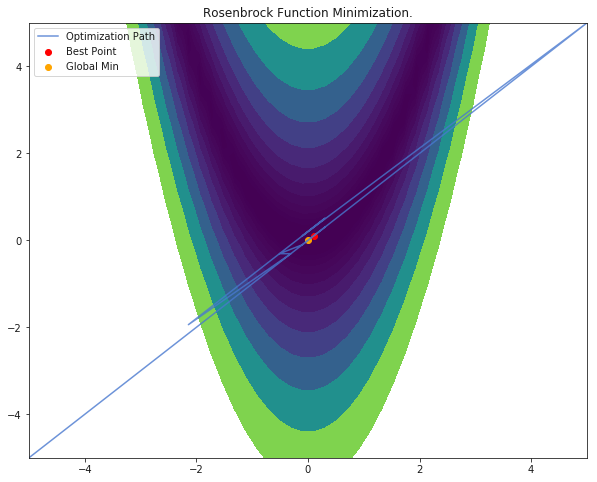

In [75]:
# Plot the above reesults 
rosenbrockfunction = lambda x,y: (1-x)**2+100*(y-x**2)**2
X,Y = np.meshgrid(np.linspace(-5,5,50),np.linspace(-5,5,50))
Z = rosenbrockfunction(X,Y)

# Plotting 
plt.figure(figsize=(10,8))
plt.contourf(X,Y,Z,np.logspace(-0.5,3.5,20,base=10))
plt.plot([i[0][0][0] for i in rosen_hist],[i[0][0][1] for i in rosen_hist],alpha=0.8,label='Optimization Path')
plt.scatter(*best_res[0].ravel(),c='red',label='Best Point')
plt.scatter(0,0,c='orange',label='Global Min')
plt.title('Rosenbrock Function Minimization.')
plt.legend()

# Print results 
print(f'Best result was {best_res[1][0]} achieved at x = {best_res[0][0]}')

### Example with sklearn model

In [111]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load the data 
x_iris, y_iris = load_iris(True)
iris_trx,iris_testx,iris_try,iris_testy = train_test_split(x_iris,y_iris,random_state=42)

# Get some initial points 
hp_x = np.array([[1e-1],[1e-2],[1e-4]])
hp_y = np.zeros(3)
for i,hp in enumerate(hp_x):
    log_reg = LogisticRegression(C=hp[0],random_state=42).fit(iris_trx,iris_try)
    test_acc = log_reg.score(iris_testx,iris_testy)
    hp_y[i] = -test_acc
    
# Make the function we want to minimize
def iris_opt(hp):
    log_reg = LogisticRegression(C=hp.ravel()[0],random_state=42).fit(iris_trx,iris_try)
    test_acc = log_reg.score(iris_testx,iris_testy)
    return -test_acc

# Make the GP instance 
iris_gp = GP(hp_x,hp_y,Matern52)

# Propose points 
c_prop = np.linspace(0,10,100).reshape(-1,1)

# Do the bayesian optimization
best_res_iris, ir_hist = iris_gp.find_best(iris_opt,c_prop,iters=10)

100%|██████████| 10/10 [00:02<00:00,  4.20it/s]


In [112]:
log_reg = LogisticRegression(C=best_res_iris[0][0][0],random_state=42).fit(iris_trx,iris_try)
test_acc = log_reg.score(iris_testx,iris_testy)
print(f'Bayesian optimization procedure found C = {best_res_iris[0][0][0]} to get test accuracy of: {test_acc}')

Bayesian optimization procedure found C = 3.9393939393939394 to get test accuracy of: 1.0


### Example with deep learning

In [117]:
# Get mnist data - Note: if this fails switch download to True
train_set = dset.MNIST(root='../mnist', train=True, transform=transforms.ToTensor(), download=False)
test_set = dset.MNIST(root='../mnist', train=False, transform=transforms.ToTensor())

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

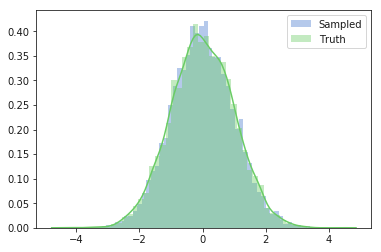

In [15]:
### TEST FOR SLICE SAMPLING ###
import scipy.stats as ss
import sampling as s

nsamps=10000
res = 0.0
trace = np.zeros(nsamps)

for i in range(nsamps):
    res = s.slice(ss.norm.logpdf,[res])
    trace[i] = res
    
sns.distplot(trace,label='Sampled',kde=False,norm_hist=True)
sns.distplot(np.random.normal(size=10000),label='Truth')
plt.legend()